In [1]:
# Import necessary librarie

import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functools

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import confusion_matrix

## Data Wrangling

In [2]:
# Download the data for the stocks
data = pd.ExcelFile('stock_prices.xlsx')

In [3]:
# Get the sheet names to download the sotck prices in different data frames
data.sheet_names

['Russia - Sberbank Rossii PAO (S',
 'Turkey - Koc Holding AS (KCHOL)',
 'Egypt - Medinet Nasr Housing (M',
 'Brazil - Minerva SABrazil (BEEF',
 'Argentina - Pampa Energia SA (P',
 'Colombia - Cementos Argos SA (C',
 'South Africa - Impala Platinum ',
 'South Korea - Dongkuk Steel Mil']

In [4]:
# Define a function to read the stock information, get the price column and rename to the stock + Price name

def read_stock(n, col_name):
    df = pd.DataFrame(data.parse(data.sheet_names[n])[['Date','Price']]).rename(columns = {'Price': col_name})
    df = df.iloc[:-1, :]
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d', errors='ignore')
    df = df.set_index('Date')
    return df

In [5]:
# Use the function for the different stock prices

S_stock = read_stock(n = 0, col_name = 'S_Price')
KCHOL_stock = read_stock(n = 1, col_name = 'KCHOL_Price')
M_stock = read_stock(n = 2, col_name = 'M_Price')
BEEF_stock = read_stock(n = 3, col_name = 'BEEF_Price')
P_stock = read_stock(n = 4, col_name = 'P_Price')
C_stock = read_stock(n = 5, col_name = 'C_Price')
IP_stock = read_stock(n = 6, col_name = 'IP_Price')
DS_stock = read_stock(n = 7, col_name = 'DS_Price')

In [6]:
# Define a function to merge the different data frames

def merge_df(df1, df2, df3, df4, df5, df6, df7, df8):
    df = [df1, df2, df3, df4, df5, df6, df7, df8]
    return functools.reduce(lambda left, right : pd.merge(left, right, how = 'left', on = 'Date'), df)

In [7]:
# Merge he data frames

stock_prices = merge_df(df1 = S_stock, df2 = KCHOL_stock, df3 = M_stock, df4 = BEEF_stock, df5 = P_stock, 
                        df6 = C_stock, df7 = IP_stock, df8 = DS_stock)

In [8]:
# Sort the index to have the dates in ascending order

stock_prices = stock_prices.sort_index()

In [9]:
# Check out the NaN Values

for col in stock_prices:
    print(col)
    print(stock_prices[col].isna().sum())

S_Price
0
KCHOL_Price
9
M_Price
77
BEEF_Price
13
P_Price
22
C_Price
20
IP_Price
10
DS_Price
14


In [10]:
# Fill the NaN values with forward filling

stock_prices_daily = stock_prices.fillna(method = 'ffill')

stock_prices_daily['M_Price'] = stock_prices['M_Price'].fillna(method = 'bfill')

# Normalize the data to have prices between 0-1 (different currencies)

stock_prices_daily_normalized = stock_prices_daily.div(stock_prices_daily.max())

In [11]:
# Resample the data weekly and monthly and do the same for the normalized data

stock_prices_weekly = stock_prices_daily.resample('W').mean()
stock_prices_weekly_normalized = stock_prices_daily_normalized.resample('W').mean()

stock_prices_monthly = stock_prices_daily.resample('M').mean()
stock_prices_monthly_normalized = stock_prices_daily_normalized.resample('M').mean()

In [12]:
# Calculate the returns for daily, weekly and monthly 

stock_returns_daily = stock_prices_daily.pct_change().dropna()

stock_returns_weekly = stock_prices_weekly.pct_change().dropna()

stock_returns_monthly = stock_prices_monthly.pct_change().dropna()

In [13]:
# Multi Period Return

def multi_period_return(period_returns):
    return np.prod(period_returns + 1) - 1

stock_returns_daily_pr = stock_returns_daily.rolling('360D').apply(multi_period_return)

In [14]:
# See the first rows for stock returns daily

stock_returns_daily.head()

,S_Price,KCHOL_Price,M_Price,BEEF_Price,P_Price,C_Price,IP_Price,DS_Price
Date,,,,,,,,
2020-01-06,-0.004314,-0.010837,0.000000,-0.000775,-0.006148,0.000000,-0.015024,-0.028814
2020-01-08,0.020677,-0.006972,0.030374,0.057409,-0.041237,-0.017143,0.045828,-0.052356
2020-01-09,-0.004476,0.024072,0.047619,-0.015407,0.036559,-0.010174,-0.016939,0.011050
2020-01-10,0.000775,0.005877,0.025974,-0.004471,-0.002075,-0.005874,-0.007784,0.001821
2020-01-13,0.016306,0.012658,0.000000,0.089820,-0.010395,-0.016248,-0.010862,0.003636


In [15]:
# See the first rows for stock returns weekly

stock_returns_weekly.head()

,S_Price,KCHOL_Price,M_Price,BEEF_Price,P_Price,C_Price,IP_Price,DS_Price
Date,,,,,,,,
2020-01-12,0.009049,-0.002709,0.054322,0.032946,-0.019980,-0.019286,0.008135,-0.061441
2020-01-19,0.008731,0.030575,0.064598,0.099437,-0.016414,-0.035397,-0.007922,-0.003521
2020-01-26,0.024912,0.015146,-0.028310,-0.023754,0.002976,0.000604,-0.024533,-0.009786
2020-02-02,-0.035809,-0.054958,0.000857,-0.168508,-0.035184,-0.016601,-0.046765,-0.071925
2020-02-09,-0.008944,-0.005995,0.006421,0.001009,0.032293,-0.010129,0.064895,0.004536


In [16]:
# See the first rows for stock returns monthly

stock_returns_monthly.head()

,S_Price,KCHOL_Price,M_Price,BEEF_Price,P_Price,C_Price,IP_Price,DS_Price
Date,,,,,,,,
2020-02-29,-0.035158,-0.052227,-0.018411,-0.115723,-0.065941,-0.093874,0.051736,-0.052666
2020-03-31,-0.208611,-0.233035,-0.288244,-0.272670,-0.125974,-0.364742,-0.395876,-0.262213
2020-04-30,-0.029628,-0.017621,-0.087966,0.116947,0.102754,0.001470,0.105588,0.040225
2020-05-31,0.002142,0.036267,-0.113204,0.373662,0.225149,-0.074671,0.098673,0.034586
2020-06-30,0.087484,0.143947,0.019610,-0.020883,-0.053766,0.007810,0.076068,0.473359


## Data Visualization

In [17]:
# Plot how the prices have been moving during time

def plot_prices(df):
    df.plot()
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc = (1.02,0))
    return plt.show()

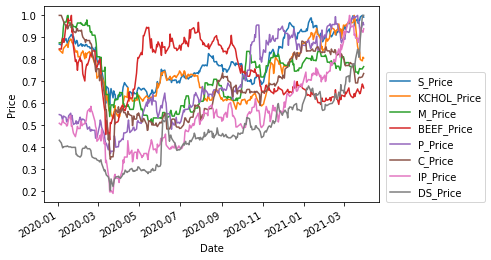

In [18]:
# Plot daily prices

plot_prices(df = stock_prices_daily_normalized)

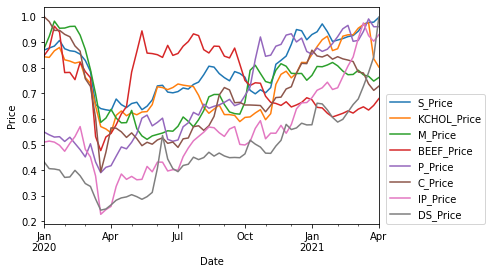

In [19]:
# Plot weekly prices

plot_prices(df = stock_prices_weekly_normalized)

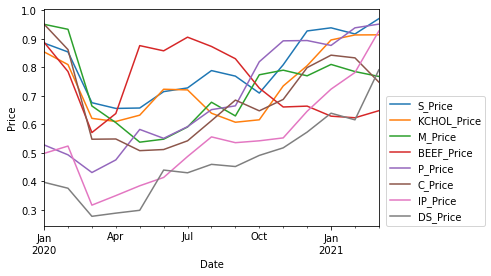

In [20]:
# Plot monthly prices

plot_prices(df = stock_prices_monthly_normalized)

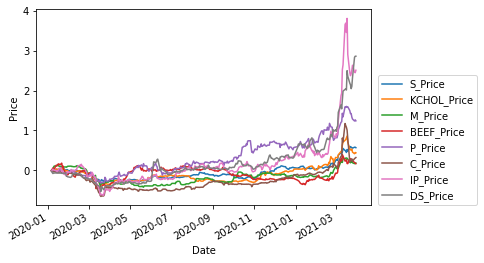

In [21]:
# Plot multiperiod return

plot_prices(df = stock_returns_daily_pr)


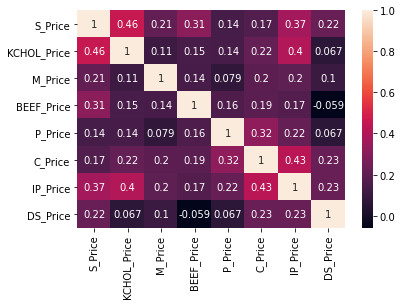

In [22]:
# Plot a correlation heatmap among all the stocks

corr_matrix = stock_returns_daily.corr()

# Plot the heatmap

sns.heatmap(corr_matrix, annot = True)
plt.show()

## Feature Engineering

In [23]:
# Define a function to use MaxMin Scaler for the modeling part

def scaler(train_array, test_array):
    scaler = MinMaxScaler(feature_range = (0,1))
    a = train_array.reshape(-1,1)
    b = test_array.reshape(-1,1)
    scaler = scaler.fit(a)
    X = scaler.transform(a)
    y = scaler.transform(b)
    return X, y

In [24]:
# Define a function to calculate the real price of the stock based on the MinMax Scaler

def scaler_inverse(train_array, predictions):
    scaler = MinMaxScaler(feature_range = (0,1))
    c = train_array.reshape(-1,1)
    scaler.fit(c)
    y_inverse = scaler.inverse_transform(predictions)
    return y_inverse

In [25]:
# Define a function to have the previous 5 days as independant features to predict the stock price

def preprocessing(dataset, time_steps = 1):
    X, y = [], []
    for i in range(len(dataset) - time_steps - 1):
        x = dataset[i:(i + time_steps), 0]
        X.append(x)
        y.append(dataset[i + time_steps, 0])
    return X, y

In [26]:
# Divide the train and test data

train = stock_prices_daily['2020']
test = stock_prices_daily['2021']

In [27]:
# Define an empty array to change the shape of the X variable (train and test)
# The new shape with treat the stock prices as each of the subarrays
# Eight stocks mean an array with shape (8, n_days)

n_days = len(stock_prices_daily)

# Define number of stocks

n_stocks = len(stock_prices_daily.columns)

# Save the number of days that are going to be used as train and test

n_days_train = len(train)
n_days_test = len(test)

# Empty array for the train and test data

train_scale = np.zeros(shape = (n_stocks, n_days_train))

test_scale = np.zeros(shape = (n_stocks, n_days_test))

# Use the for loop to iterate over the train and test to have the array shape changed

for i in range(0, n_stocks):
    train_scale[i] = train.iloc[:,i]
    
for i in range(0, n_stocks):
    test_scale[i] = test.iloc[:,i]


### Apply the Scaler function to the stocks

In [28]:
# Empty arrays for the train and test data (n_stocks, ndays, 1) to make it usable after using the MinMax Scaler

Xtrain = np.empty(shape = (n_stocks, n_days_train, 1))

Xtest = np.empty(shape = (n_stocks, n_days_test, 1))

# For loop to create the Xtrain and Xtest and scale the data (by just fitting the train data). 
# The idea is to avoid the data leakage by scaling the complete data set

for i in range(n_stocks):
    Xtrain[i], Xtest[i] = scaler(train_array = train_scale[i], test_array = test_scale[i])
    

In [29]:
# Get together the Xtrain and Xtest to apply some feature engineering (Make previous 5 days as independent variables)
# and the day ahead the dependant variable

# Define the empty array to iterate over an array (more time efficient)

Values = np.empty(shape = (n_stocks, n_days, 1))

#Iterate by concatenating the Xtrain and Xtest

for i in range(n_stocks):
    Values[i] = np.concatenate((Xtrain[i], Xtest[i]))

In [30]:
# Use the function to use the previous 5 days as independent features for train data

time_steps = 5

# Make two empty list to store the data

X = []
y = []

for i in range(0, n_stocks):
    # Use the preprocessing function 
    a,b = preprocessing(dataset = Values[i], time_steps = time_steps)
    # Apend the values
    X.append(a)
    y.append(b)

# Make sure to have them as arrays

X = np.array(X)
y = np.array(y)

In [31]:
# X_train array will have new shape

# Define the new days for each subarray

n_days_train_resample = n_days_train - time_steps - 1

# Make empty arrays with the reshape of the data after taking the 5 days as independant variables

X_train = np.empty(shape = (n_stocks, n_days_train_resample, 5))

y_train = np.empty(shape = (n_stocks, n_days_train_resample))

X_test = np.empty(shape = (n_stocks, n_days_test, 5))

y_test = np.empty(shape = (n_stocks, n_days_test))

In [32]:
# Start for the X_train, y_train, X_test, y_test

for i in range(n_stocks):
    X_train[i], y_train[i] = X[i][:n_days_train_resample], y[i][:n_days_train_resample]
    X_test[i], y_test[i] = X[i][n_days_train_resample:], y[i][n_days_train_resample:]

In [33]:
# Reshape input to be [samples, time steps, features] which is required for LSTM

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , X_test.shape[2], 1)

In [34]:
print('Shape of the train data to use at the model', X_train.shape, y_train.shape)
print('Shape of the test data to use', X_test.shape, y_test.shape)

Shape of the train data to use at the model (8, 244, 5, 1) (8, 244)
Shape of the test data to use (8, 61, 5, 1) (8, 61)


## Modeling

In [35]:
# Define a model to build the neural network

def neural_network():
    # Begin with Sequential
    regressor = Sequential()
    # The first layer would the be LSTM
    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (5,1)))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return regressor

In [36]:
# Define a variable to reshape the train and test data into shape (, , 1) to make it processable on the neural network

def variables_model(n):
    x_train, Y_train = X_train[n], y_train[n]
    x_test, Y_test = X_test[n], y_test[n]
    
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
    
    return (x_train, x_test, Y_train, Y_test)
    

In [37]:
# Fit the model and get the predictions

def model_fit(Xtr, ytr, Xte):
    model.fit(Xtr, ytr, epochs = 100, batch_size = 32)
    pred = model.predict(Xte)
    return pred

In [38]:
# For future use in plotting, create one data frame to have the train values plus the test values
# and another pandas series to have the train data plus the predicted values

def df_merger(train_data, test_data, pred_values):
    actual_data = train_data.append(test_data)
    predicted_data = train_data.append(pred_values)
    return actual_data, predicted_data

In [39]:
# Compare actual values with predicted values with a plot

def plot_comparison(actual, predicted, string):
    #Visualizing the prediction
    plt.figure(figsize=(10,6))
    plt.plot(actual[:'2020-12-30'], color = 'blue')
    plt.plot(actual['2020-12-30':], color = 'orange', label = 'Actual Values')
    plt.plot(predicted['2020-12-30':], color = 'green', label = 'Predicted Values')
    plt.title(string)
    plt.xlabel('Trading Day')
    plt.ylabel('Price')
    plt.legend()
    return plt.show()
    

In [40]:
# Save a data frame to concat all the predictions

# Start with an empty data frame
predictions_df = pd.DataFrame()

# Start with the same date than the test for the comparisons.
predictions_df['Date'] = test.index

#Set the date as the index
predictions_df.set_index('Date', inplace = True)

In [41]:
# Define the model

model = neural_network()

In [42]:
# Check the summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 50)             10400     
_________________________________________________________________
dropout (Dropout)            (None, 5, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

### S_Stock

In [43]:
# Get the data for this stock

S_Xtrain, S_Xtest, S_ytrain, S_ytest = variables_model(n = 0)

In [44]:
# Fit the data for the stock

S_pred = model_fit(Xtr = S_Xtrain, ytr = S_ytrain, Xte = S_Xtest)


Epoch 1/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1932
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0552
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0372
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0236
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0207
Epoch 6/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0155
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0130
Epoch 8/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0088
Epoch 9/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0106
Epoch 10/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0101
Epoch 11/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0093
Epoch 12/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0093
Epoch 13/100
8/8 [==============================] -

In [45]:
# Use the inverse transform function

S_pred_prices = scaler_inverse(train_array = train['S_Price'].values, predictions = S_pred)


In [46]:
# Add the first column to the data frame that will store the predictions

predictions_df['S_Price'] = S_pred_prices


In [47]:
# Get the actual and predicted data as data frames for both

S_actual, S_predicted = df_merger(train_data = train['S_Price'], test_data = test['S_Price'], 
                                  pred_values = predictions_df['S_Price'])


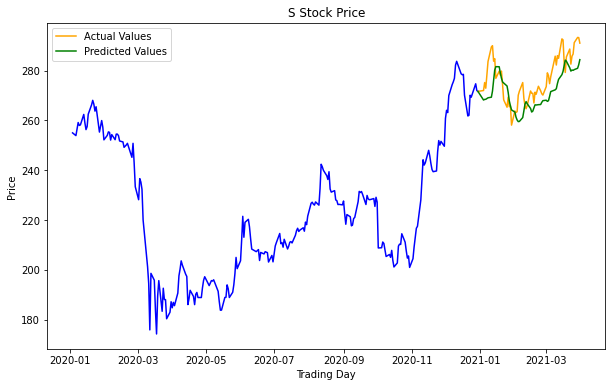

In [48]:
# Plot the S Stock Price comparison

plot_comparison(actual = S_actual, predicted = S_predicted, string = 'S Stock Price')

### KCHOL Stock

In [49]:
# Get the data for this stock

KCHOL_Xtrain, KCHOL_Xtest, KCHOL_ytrain, KCHOL_ytest = variables_model(n = 1)

In [50]:
# Fit the model

KCHOL_pred = model_fit(Xtr = KCHOL_Xtrain, ytr = KCHOL_ytrain, Xte = KCHOL_Xtest)

Epoch 1/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0065
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0072
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0069
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0077
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0074
Epoch 6/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0064
Epoch 7/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0067
Epoch 8/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0069
Epoch 9/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0067
Epoch 10/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0066
Epoch 11/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0068
Epoch 12/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0061
Epoch 13/100
8/8 [==============================]

In [51]:
# Save the actual and predicted values in different data frames to plot

KCHOL_pred_prices = scaler_inverse(train_array = train['KCHOL_Price'].values, predictions = KCHOL_pred)

In [52]:
# Add the first column to the data frame that will store the predictions

predictions_df['KCHOL_Price'] = KCHOL_pred_prices

In [53]:
# Get the actual and predicted data as data frames for both

KCHOL_actual, KCHOL_predicted = df_merger(train_data = train['KCHOL_Price'], test_data = test['KCHOL_Price'], 
                                  pred_values = predictions_df['KCHOL_Price'])

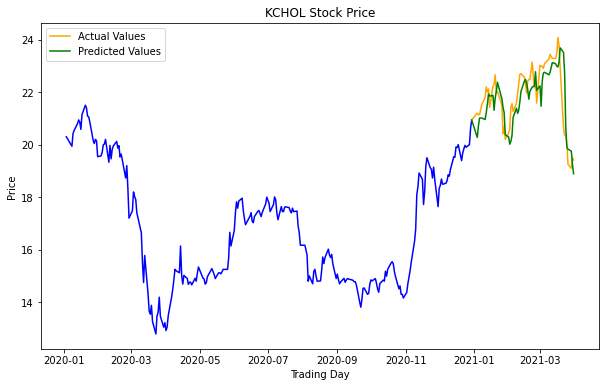

In [54]:
# Plot the Stock Price comparison

plot_comparison(actual = KCHOL_actual, predicted = KCHOL_predicted, string = 'KCHOL Stock Price')

### M Stock

In [55]:
# Get the data for this stock

M_Xtrain, M_Xtest, M_ytrain, M_ytest = variables_model(n = 2)

In [56]:
# Fit the model

M_pred = model_fit(Xtr = M_Xtrain, ytr = M_ytrain, Xte = M_Xtest)

Epoch 1/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0028
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0031
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0035
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0029
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0031
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0033
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0036
Epoch 8/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0029
Epoch 9/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0028
Epoch 10/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0034
Epoch 11/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0039
Epoch 12/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0029
Epoch 13/100
8/8 [==============================]

In [57]:
# Save the actual and predicted values in different data frames to plot

M_pred_prices = scaler_inverse(train_array = train['M_Price'].values, predictions = M_pred)

In [58]:
# Add the first column to the data frame that will store the predictions

predictions_df['M_Price'] = M_pred_prices

In [59]:
# Get the actual and predicted data as data frames for both

M_actual, M_predicted = df_merger(train_data = train['M_Price'], test_data = test['M_Price'], 
                                  pred_values = predictions_df['M_Price'])

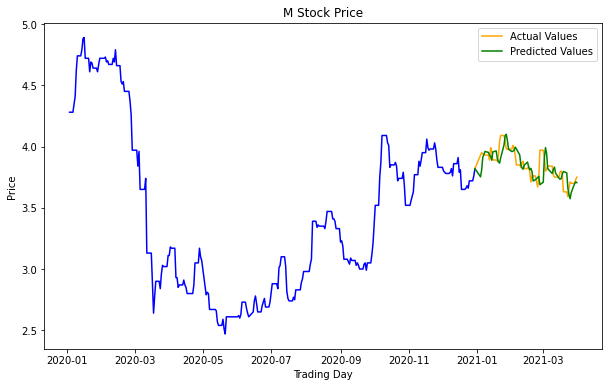

In [60]:
# Plot the Stock Price comparison

plot_comparison(actual = M_actual, predicted = M_predicted, string = 'M Stock Price')

### BEEF Stock

In [61]:
# Get the data for this stock

BEEF_Xtrain, BEEF_Xtest, BEEF_ytrain, BEEF_ytest = variables_model(n = 3)

In [62]:
# Fit the model

BEEF_pred = model_fit(Xtr = BEEF_Xtrain, ytr = BEEF_ytrain, Xte = BEEF_Xtest)

Epoch 1/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0036
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0041
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0044
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0043
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0041
Epoch 6/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0043
Epoch 7/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0044
Epoch 8/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0035
Epoch 9/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0035
Epoch 10/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0038
Epoch 11/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0045
Epoch 12/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0039
Epoch 13/100
8/8 [==============================]

In [63]:
# Save the actual and predicted values in different data frames to plot

BEEF_pred_prices = scaler_inverse(train_array = train['BEEF_Price'].values, predictions = BEEF_pred)

In [64]:
# Add the first column to the data frame that will store the predictions

predictions_df['BEEF_Price'] = BEEF_pred_prices

In [65]:
# Get the actual and predicted data as data frames for both

BEEF_actual, BEEF_predicted = df_merger(train_data = train['BEEF_Price'], test_data = test['BEEF_Price'], 
                                  pred_values = predictions_df['BEEF_Price'])

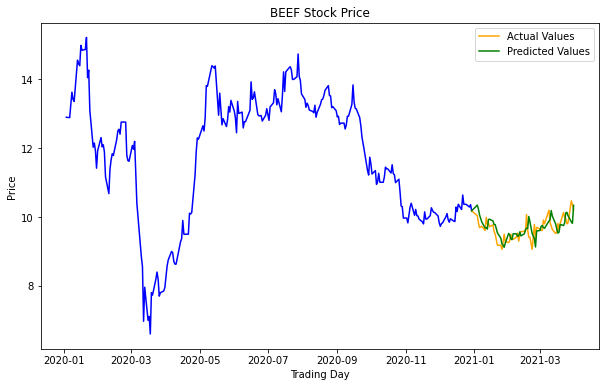

In [66]:
# Plot the Stock Price comparison

plot_comparison(actual = BEEF_actual, predicted = BEEF_predicted, string = 'BEEF Stock Price')

### P Stock

In [67]:
# Get the data for this stock

P_Xtrain, P_Xtest, P_ytrain, P_ytest = variables_model(n = 4)

In [68]:
# Fit the model

P_pred = model_fit(Xtr = P_Xtrain, ytr = P_ytrain, Xte = P_Xtest)

Epoch 1/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0025
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0027
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0029
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0027
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0025
Epoch 6/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0026
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0026
Epoch 8/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0021
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0024
Epoch 10/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0022
Epoch 11/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0026
Epoch 12/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0031
Epoch 13/100
8/8 [==============================]

In [69]:
# Save the actual and predicted values in different data frames to plot

P_pred_prices = scaler_inverse(train_array = train['P_Price'].values, predictions = P_pred)

In [70]:
# Add the first column to the data frame that will store the predictions

predictions_df['P_Price'] = P_pred_prices

In [71]:
# Get the actual and predicted data as data frames for both

P_actual, P_predicted = df_merger(train_data = train['P_Price'], test_data = test['P_Price'], 
                                  pred_values = predictions_df['P_Price'])

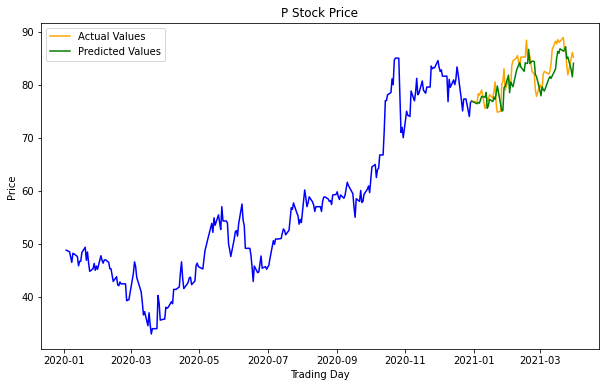

In [72]:
# Plot the Stock Price comparison

plot_comparison(actual = P_actual, predicted = P_predicted, string = 'P Stock Price')

### C Stock

In [73]:
# Get the data for this stock

C_Xtrain, C_Xtest, C_ytrain, C_ytest = variables_model(n = 5)

In [74]:
# Fit the model

C_pred = model_fit(Xtr = C_Xtrain, ytr = C_ytrain, Xte = C_Xtest)

Epoch 1/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0017
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0016
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0022
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0019
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0016
Epoch 6/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0018
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0017
Epoch 8/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0015
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0014
Epoch 10/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0020
Epoch 11/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0015
Epoch 12/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0016
Epoch 13/100
8/8 [==============================]

In [75]:
# Save the actual and predicted values in different data frames to plot

C_pred_prices = scaler_inverse(train_array = train['C_Price'].values, predictions = C_pred)

In [76]:
# Add the first column to the data frame that will store the predictions

predictions_df['C_Price'] = C_pred_prices

In [77]:
# Get the actual and predicted data as data frames for both

C_actual, C_predicted = df_merger(train_data = train['C_Price'], test_data = test['C_Price'], 
                                  pred_values = predictions_df['C_Price'])

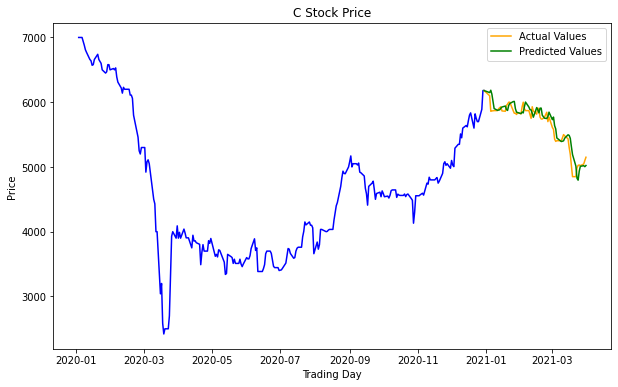

In [78]:
# Plot the Stock Price comparison

plot_comparison(actual = C_actual, predicted = C_predicted, string = 'C Stock Price')

### IP Stock

In [79]:
# Get the data for this stock

IP_Xtrain, IP_Xtest, IP_ytrain, IP_ytest = variables_model(n = 6)

In [80]:
# Fit the model

IP_pred = model_fit(Xtr = IP_Xtrain, ytr = IP_ytrain, Xte = IP_Xtest)

Epoch 1/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0030
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0030
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0029
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0033
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0028
Epoch 6/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0027
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0030
Epoch 8/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0032
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0031
Epoch 10/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0026
Epoch 11/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0026
Epoch 12/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0026
Epoch 13/100
8/8 [==============================]

In [81]:
# Save the actual and predicted values in different data frames to plot

IP_pred_prices = scaler_inverse(train_array = train['IP_Price'].values, predictions = IP_pred)

In [82]:
# Add the first column to the data frame that will store the predictions

predictions_df['IP_Price'] = IP_pred_prices

In [83]:
# Get the actual and predicted data as data frames for both

IP_actual, IP_predicted = df_merger(train_data = train['IP_Price'], test_data = test['IP_Price'], 
                                  pred_values = predictions_df['IP_Price'])

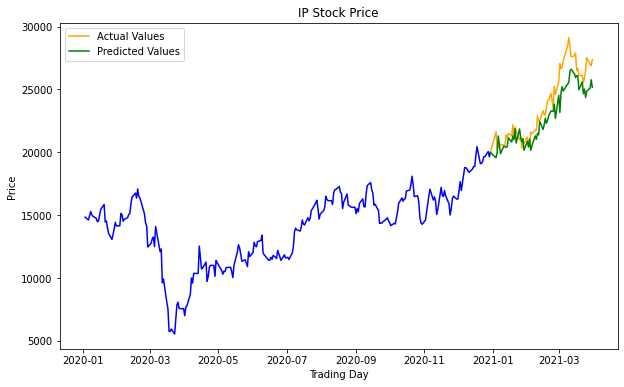

In [84]:
# Plot the Stock Price comparison

plot_comparison(actual = IP_actual, predicted = IP_predicted, string = 'IP Stock Price')

### DS Stock

In [85]:
# Get the data for this stock

DS_Xtrain, DS_Xtest, DS_ytrain, DS_ytest = variables_model(n = 7)

In [86]:
# Fit the model

DS_pred = model_fit(Xtr = DS_Xtrain, ytr = DS_ytrain, Xte = DS_Xtest)

Epoch 1/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0026
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0029
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0022
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0025
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0024
Epoch 6/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0029
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0026
Epoch 8/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0032
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0028
Epoch 10/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0026
Epoch 11/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0023
Epoch 12/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0024
Epoch 13/100
8/8 [==============================] 

In [87]:
# Save the actual and predicted values in different data frames to plot

DS_pred_prices = scaler_inverse(train_array = train['DS_Price'].values, predictions = DS_pred)

In [88]:
# Add the first column to the data frame that will store the predictions

predictions_df['DS_Price'] = DS_pred_prices

In [89]:
# Get the actual and predicted data as data frames for both

DS_actual, DS_predicted = df_merger(train_data = train['DS_Price'], test_data = test['DS_Price'], 
                                  pred_values = predictions_df['DS_Price'])

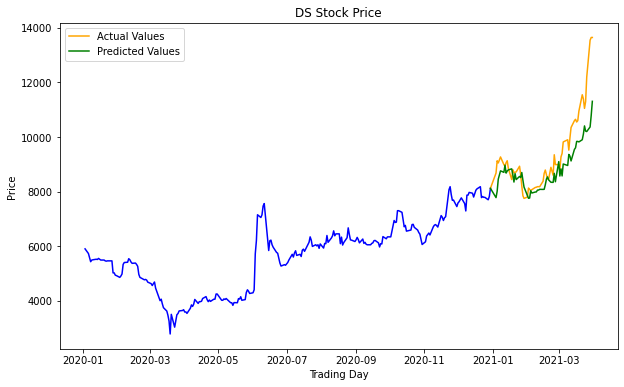

In [90]:
# Plot the Stock Price comparison

plot_comparison(actual = DS_actual, predicted = DS_predicted, string = 'DS Stock Price')

### Model Evaluation

In [91]:
def capital_gain_predicted_prices(df1, df2):
    # Define the total capital gain as the final value minus the initial value divided by the initial value
    actual_returns = (df1[-1] - df1[0])/df1[0]
    # Predicted returns 
    predicted_returns = (df2[-1] - df2[0])/df2[0]
    # Show the value as percentage
    actual_returns = round(actual_returns*100,2)
    predicted_returns = round(predicted_returns*100, 2)
    print('The actual returns had a value of {}% and the predicted returns had a value {}%'.format(actual_returns, 
                                                                                                predicted_returns))

In [92]:
# Define a function for the Bollinger brands

def bollinger_bands(df, col, p, std):
    # Create a new data frame just to use in the function to plot the upper, and lower bound with the moving average
    # and the closing price
    bollinger_df = pd.DataFrame()
    #Establish the serie to use the rolling function
    bollinger_df[col] = df[col].astype(int)
    # Define number of periods
    period = p
    # Apply the rolling function for the moving average
    bollinger_df['SMA'] = bollinger_df.rolling(window = period).mean()
    # Calculate the Standard Deviation
    bollinger_df['std'] = bollinger_df[col].rolling(window = period).std()
    # Establish the upper border
    bollinger_df['upper'] = bollinger_df['SMA'] + (bollinger_df['std'] * std)
    # Establish the lower border
    bollinger_df['lower'] = bollinger_df['SMA'] - (bollinger_df['std'] * std)
    
    # Define the conditions to make the buy/sell recommendations
    buy_signal = []
    sell_signal = []
    
    # Start a for loop
    for i in range(len(bollinger_df[col])):
        if bollinger_df[col][i] > bollinger_df['upper'][i]: # This is the condition for sell recommendation 
            buy_signal.append(np.nan)
            sell_signal.append(bollinger_df[col][i])
        elif bollinger_df[col][i] < bollinger_df['lower'][i]: # This is the condition for buy recommendation
            buy_signal.append(bollinger_df[col][i])
            sell_signal.append(np.nan)
        else: # If none of the conditions are met, then no recommendation is given
            buy_signal.append(np.nan)
            sell_signal.append(np.nan)
    # Add the recommendations as a columns in the data frame
    bollinger_df['buy'] = buy_signal
    bollinger_df['sell'] = sell_signal
    
    # Plot the bollinger bands in order to make the sell and buy recommendations
    fig = plt.figure(figsize = (20,12))
    # Add subplot
    ax = fig.add_subplot(1,1,1)
    # Get the index
    x_axis = bollinger_df.index
    # Plot the shade area between the upper and the lower bound
    ax.fill_between(x_axis, bollinger_df['upper'], bollinger_df['lower'], color = 'grey')
    # Plot the closing price, moving average and buy and sell recommendations
    ax.plot(x_axis, bollinger_df[col], color = 'gold', lw = 3, label = 'Price')
    ax.plot(x_axis, bollinger_df['SMA'], color = 'blue', lw = 3, label = 'Moving Averag')
    ax.scatter(x_axis, bollinger_df['buy'], color = 'green', lw = 3, marker = '^', label = 'Buy', s = 100)
    ax.scatter(x_axis, bollinger_df['sell'], color = 'red', lw = 3, marker = 'v', label = 'Sell', s = 100)
    # Set the axis
    ax.set_title('Bollinger bands for {}'.format(col))
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.xticks(rotation = 45)
    ax.legend(loc = (1.02, 0.6))
    return plt.show()


In [93]:
# Get a data frame that stores the train and predicted data frame for the bollinger bands

predicted_df = merge_df(df1 = S_predicted, df2 = KCHOL_predicted, df3 = M_predicted, df4 = BEEF_predicted, 
                        df5 = P_predicted, df6 = C_predicted, df7 = IP_predicted, df8 = DS_predicted)

### S_Stock

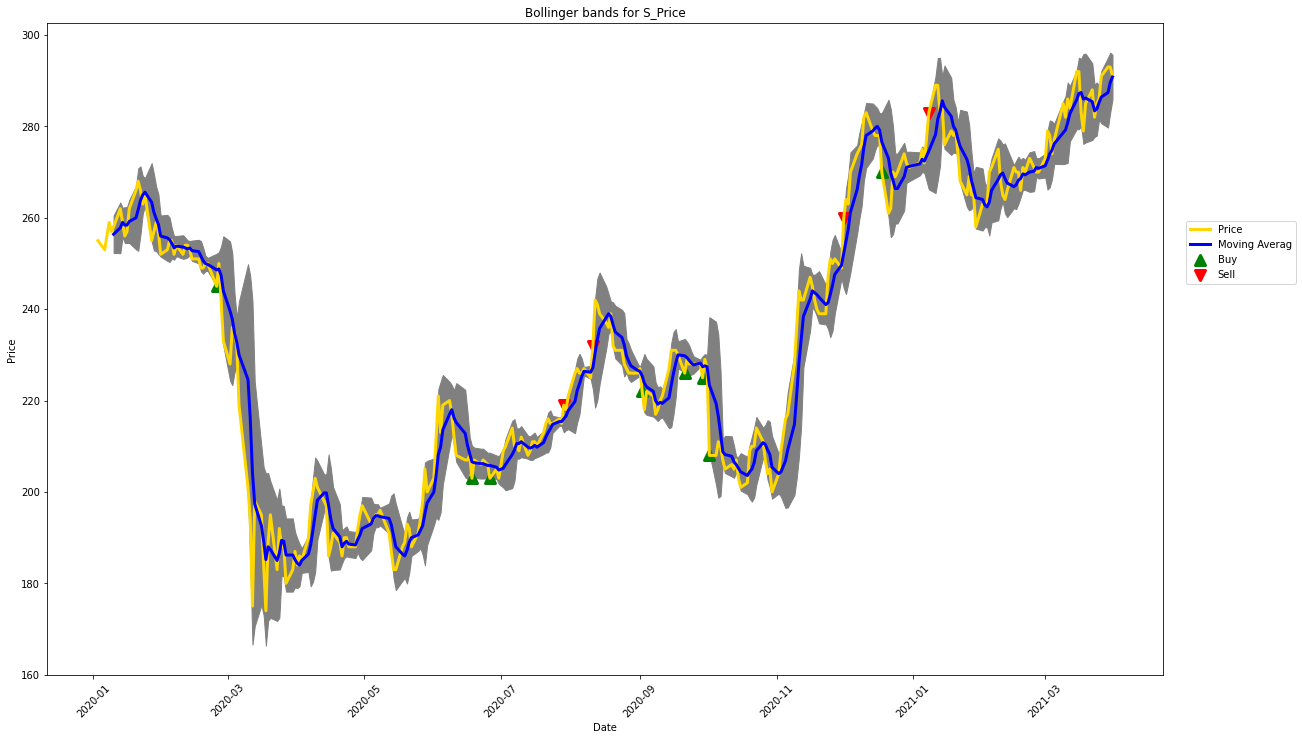

In [94]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'S_Price', p = 5, std = 1.7)

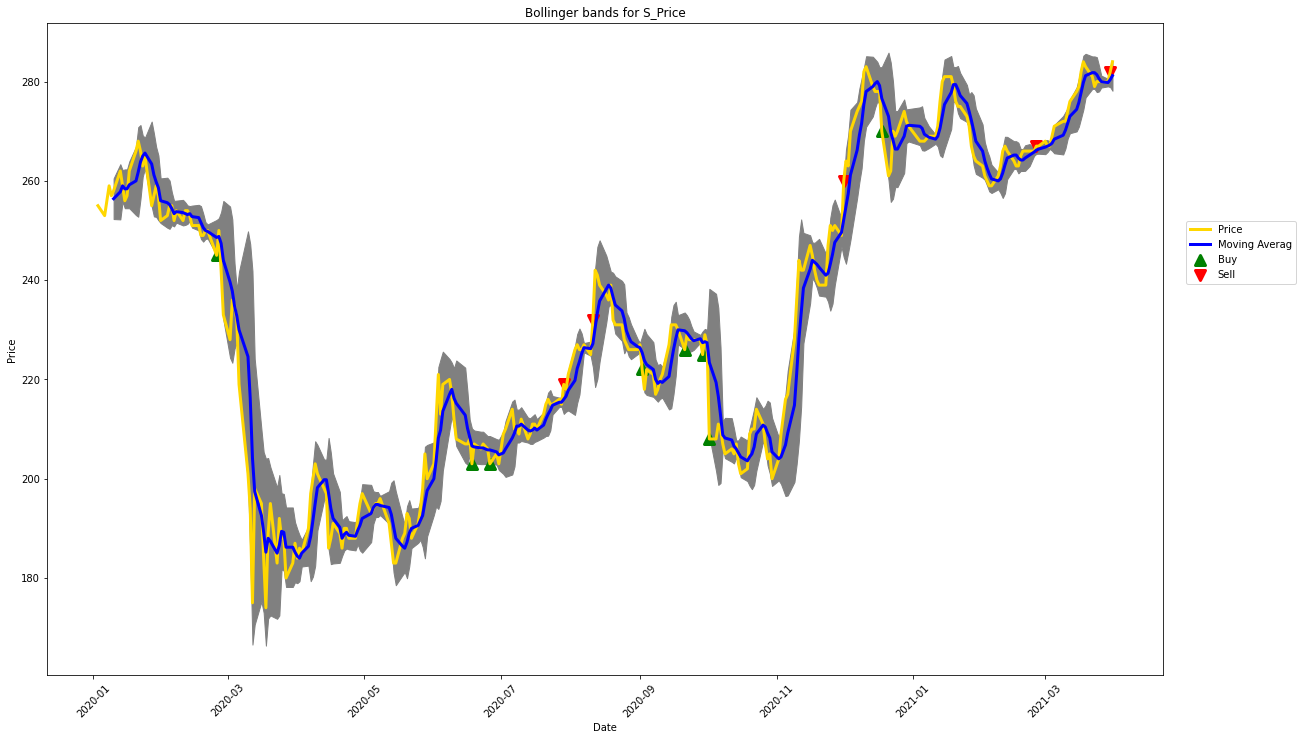

In [95]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'S_Price', p = 5, std = 1.7)

In [96]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['S_Price'], df2 = predictions_df['S_Price'])

The actual returns had a value of 6.99% and the predicted returns had a value 6.04%


### KCHOL Stock

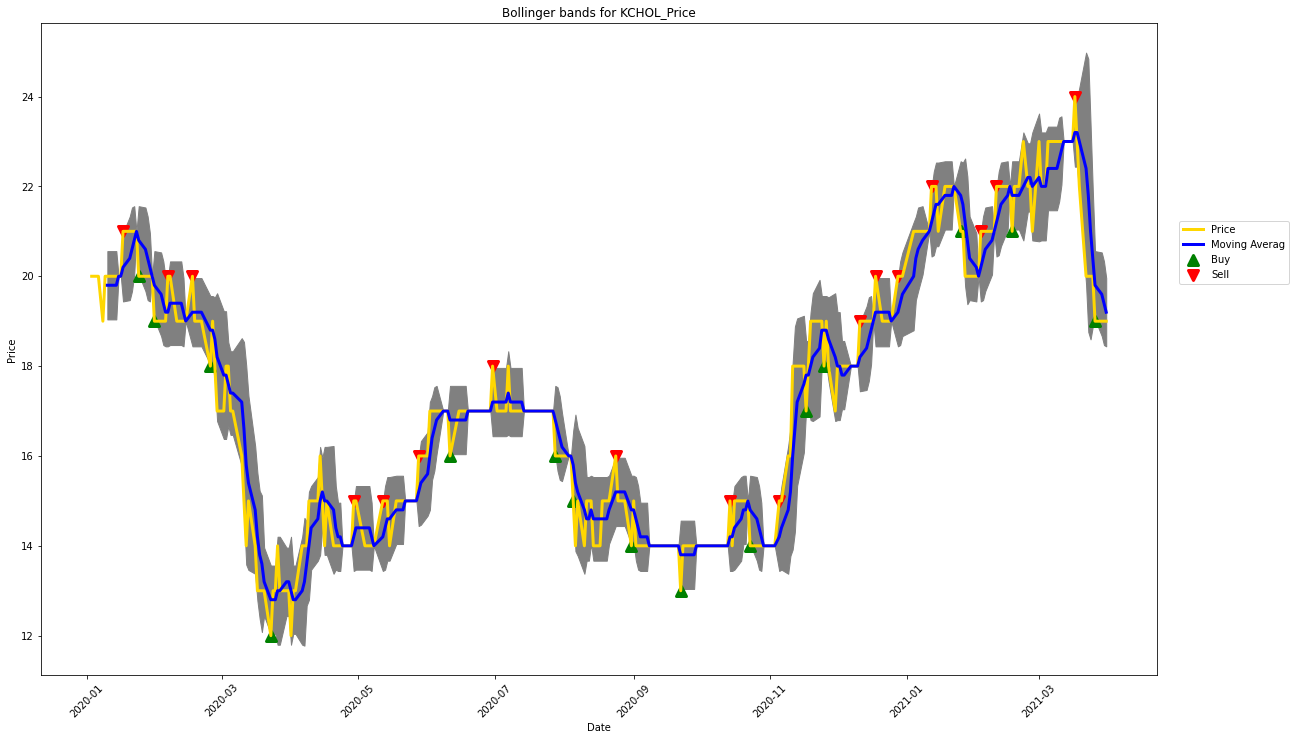

In [97]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'KCHOL_Price', p = 5, std = 1.7)

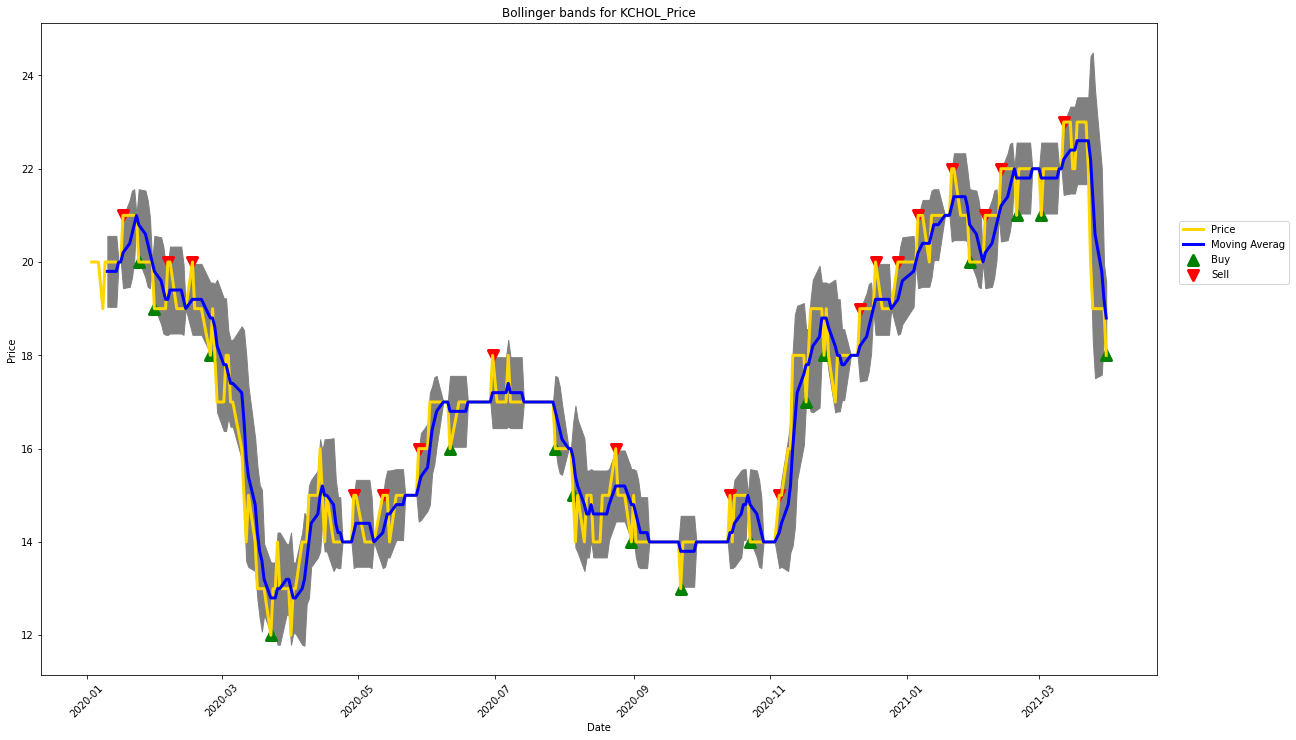

In [98]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'KCHOL_Price', p = 5, std = 1.7)

In [99]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['KCHOL_Price'], df2 = predictions_df['KCHOL_Price'])

The actual returns had a value of -8.44% and the predicted returns had a value -6.8%


### M Stock

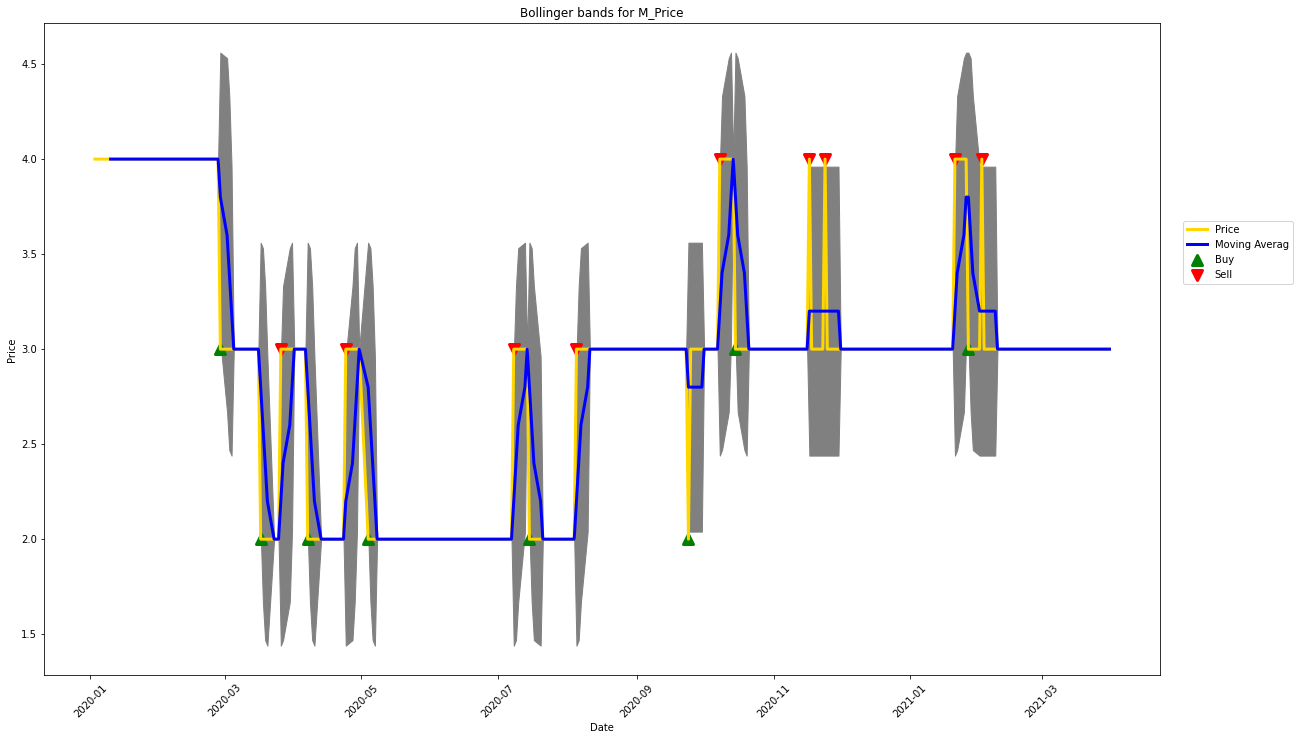

In [100]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'M_Price', p = 5, std = 1.7)

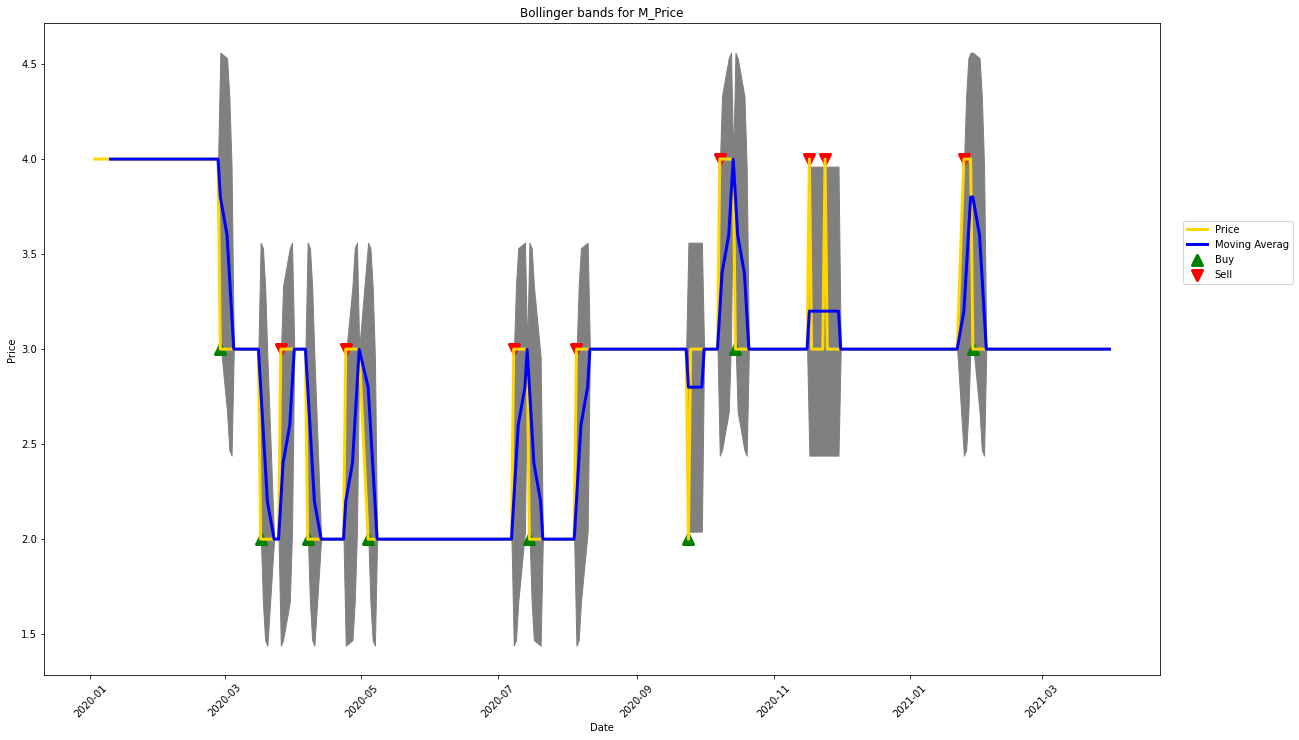

In [101]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'M_Price', p = 5, std = 1.7)

In [102]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['M_Price'], df2 = predictions_df['M_Price'])

The actual returns had a value of -4.58% and the predicted returns had a value -1.26%


### BEEF Stock

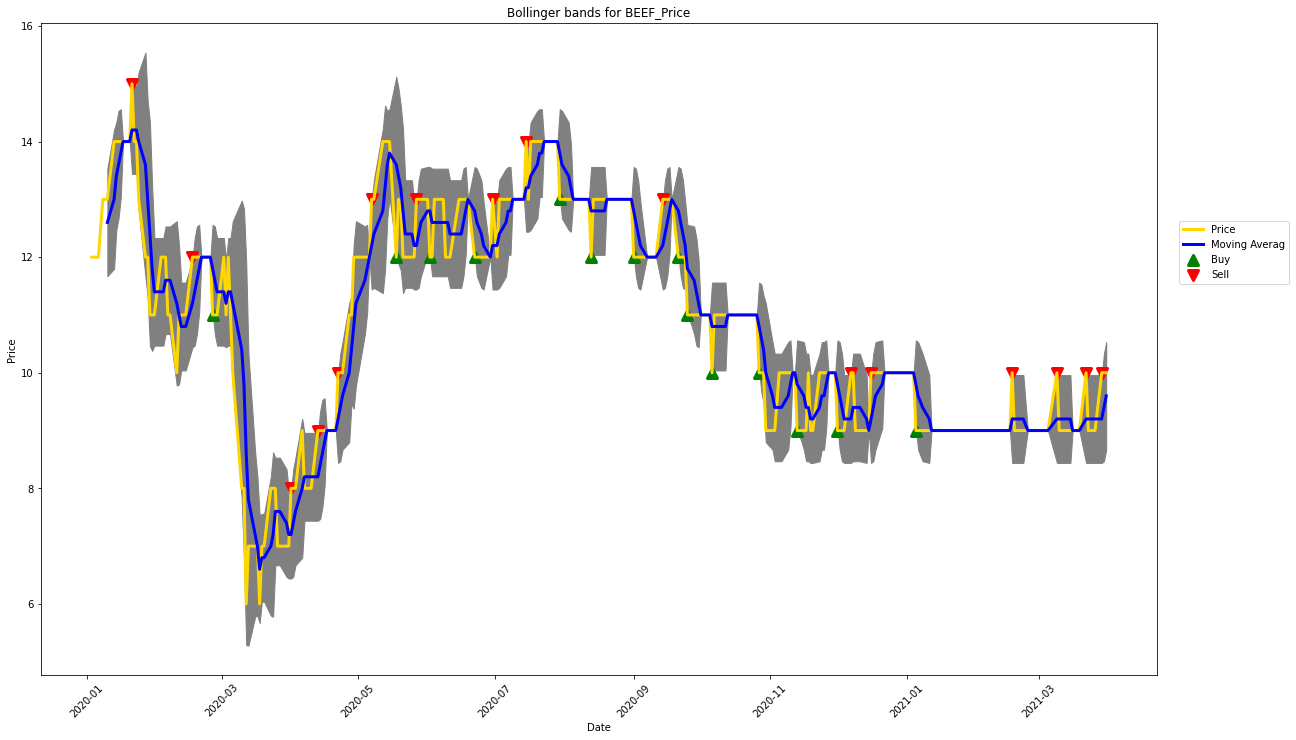

In [103]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'BEEF_Price', p = 5, std = 1.7)

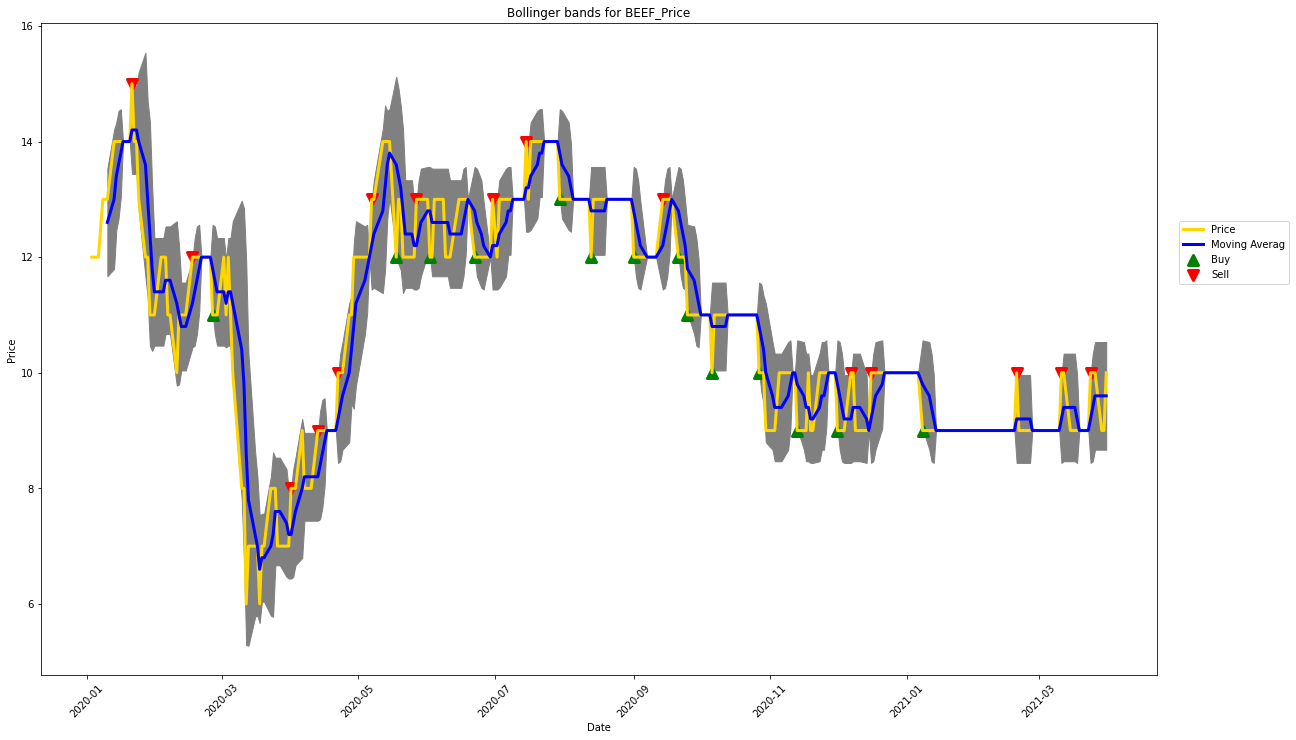

In [104]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'BEEF_Price', p = 5, std = 1.7)

In [105]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['BEEF_Price'], df2 = predictions_df['BEEF_Price'])

The actual returns had a value of 1.59% and the predicted returns had a value -0.07%


### P Stock

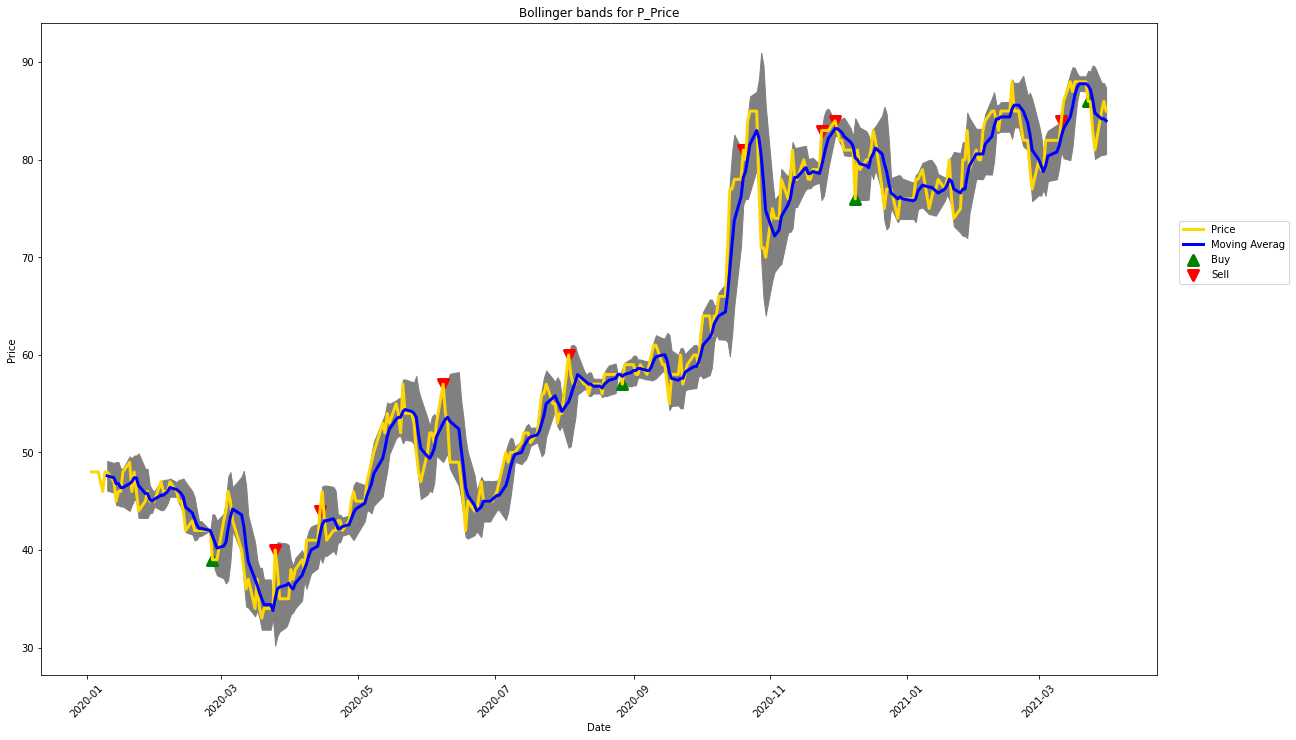

In [106]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'P_Price', p = 5, std = 1.7)

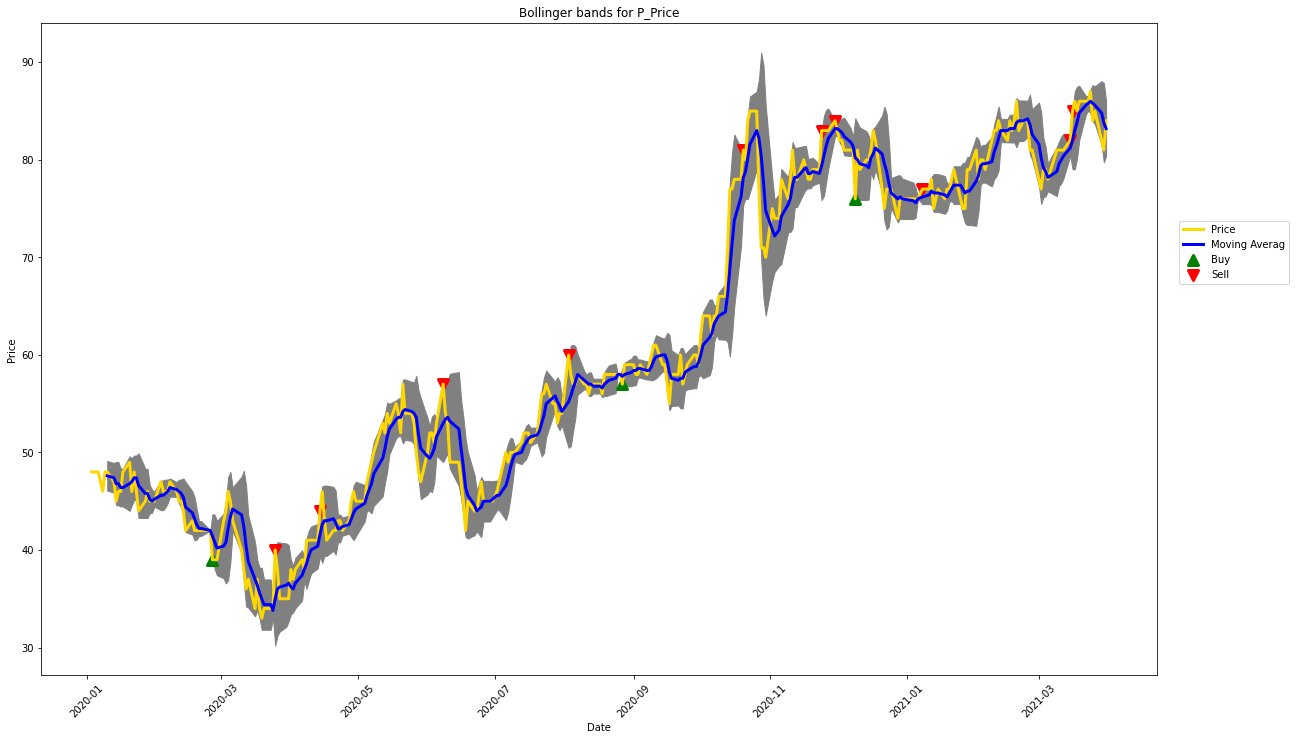

In [107]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'P_Price', p = 5, std = 1.7)

In [108]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['P_Price'], df2 = predictions_df['P_Price'])

The actual returns had a value of 11.02% and the predicted returns had a value 9.99%


### C Stock

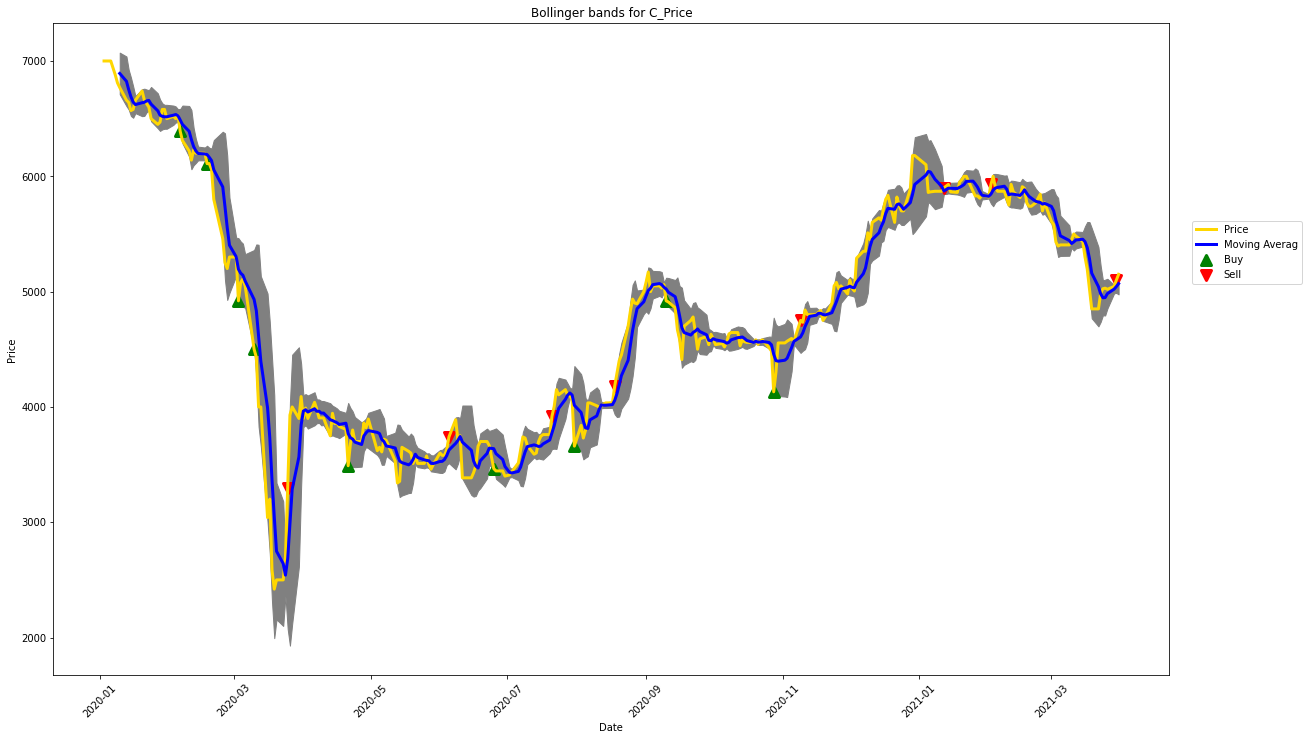

In [109]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'C_Price', p = 5, std = 1.7)

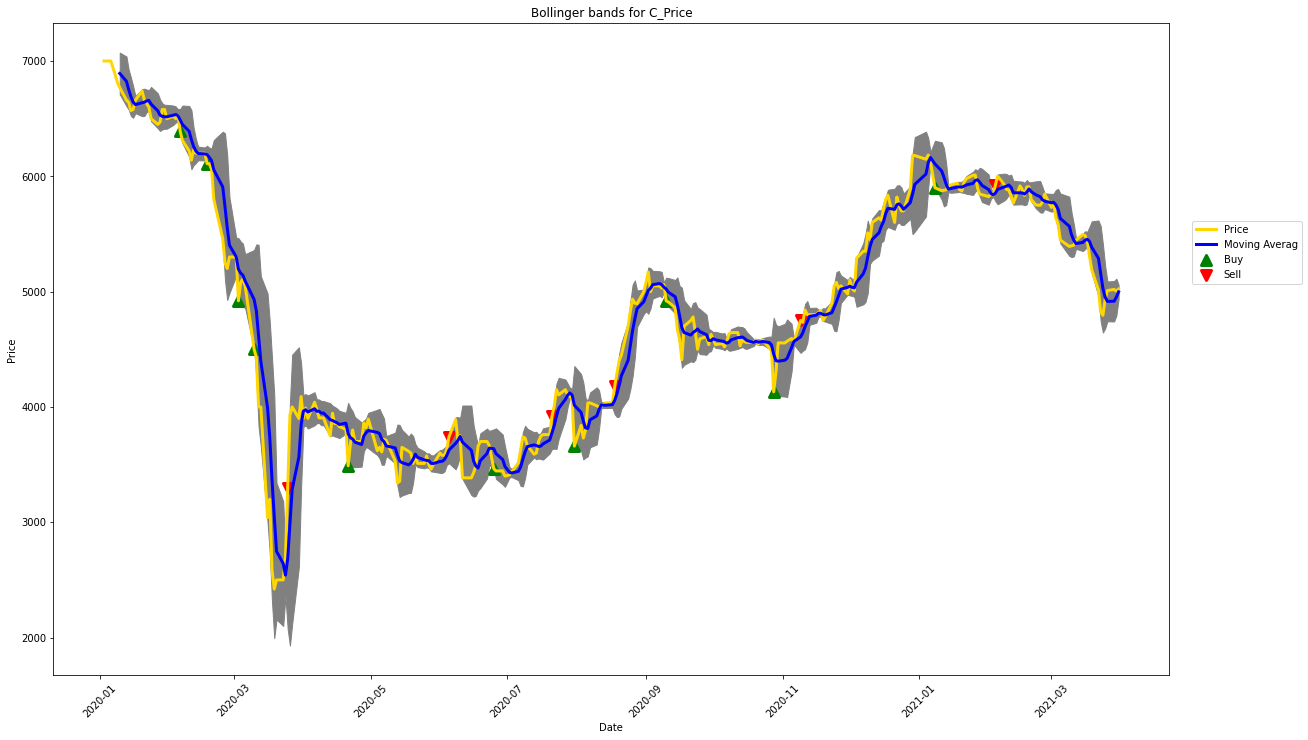

In [110]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'C_Price', p = 5, std = 1.7)

In [111]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['C_Price'], df2 = predictions_df['C_Price'])

The actual returns had a value of -15.57% and the predicted returns had a value -18.32%


### IP Stock

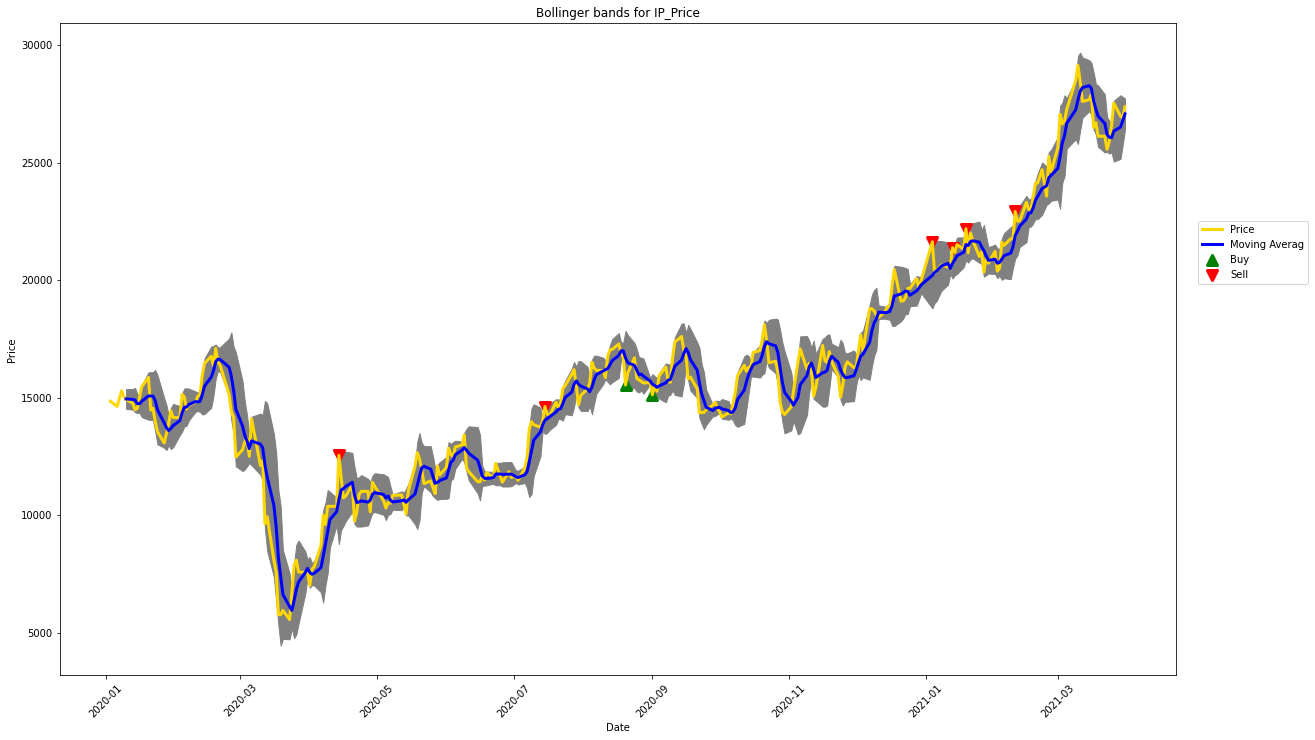

In [112]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'IP_Price', p = 5, std = 1.7)

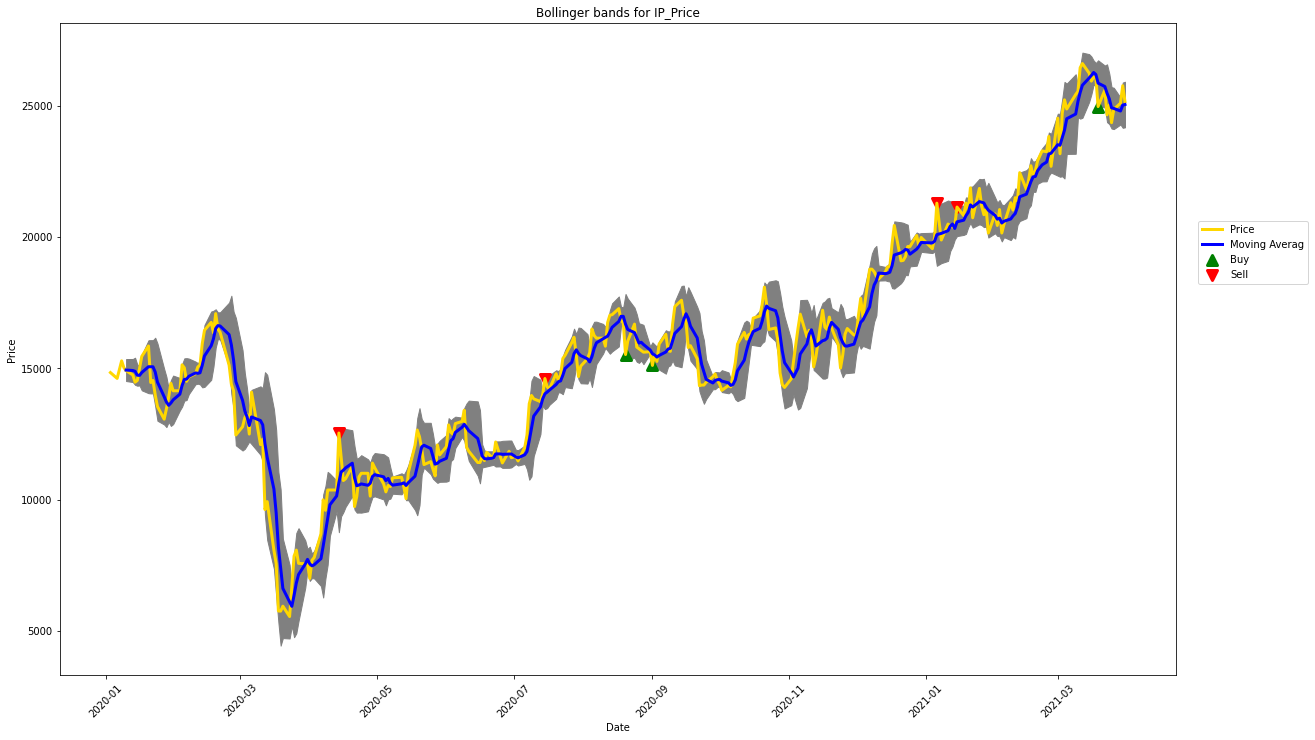

In [113]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'IP_Price', p = 5, std = 1.7)

In [114]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['IP_Price'], df2 = predictions_df['IP_Price'])

The actual returns had a value of 26.56% and the predicted returns had a value 28.63%


### DS Stock

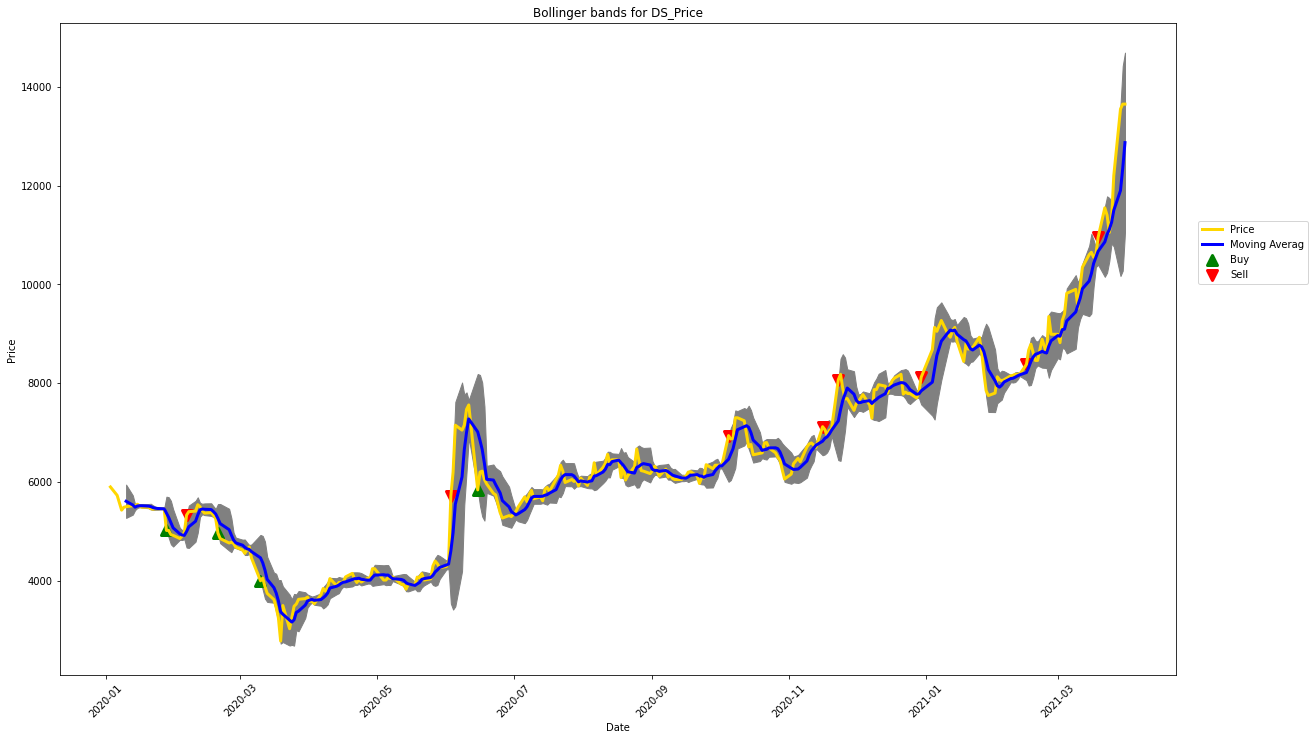

In [115]:
# Bollinger bands for the actual data daily

bollinger_bands(df = stock_prices_daily, col = 'DS_Price', p = 5, std = 1.7)

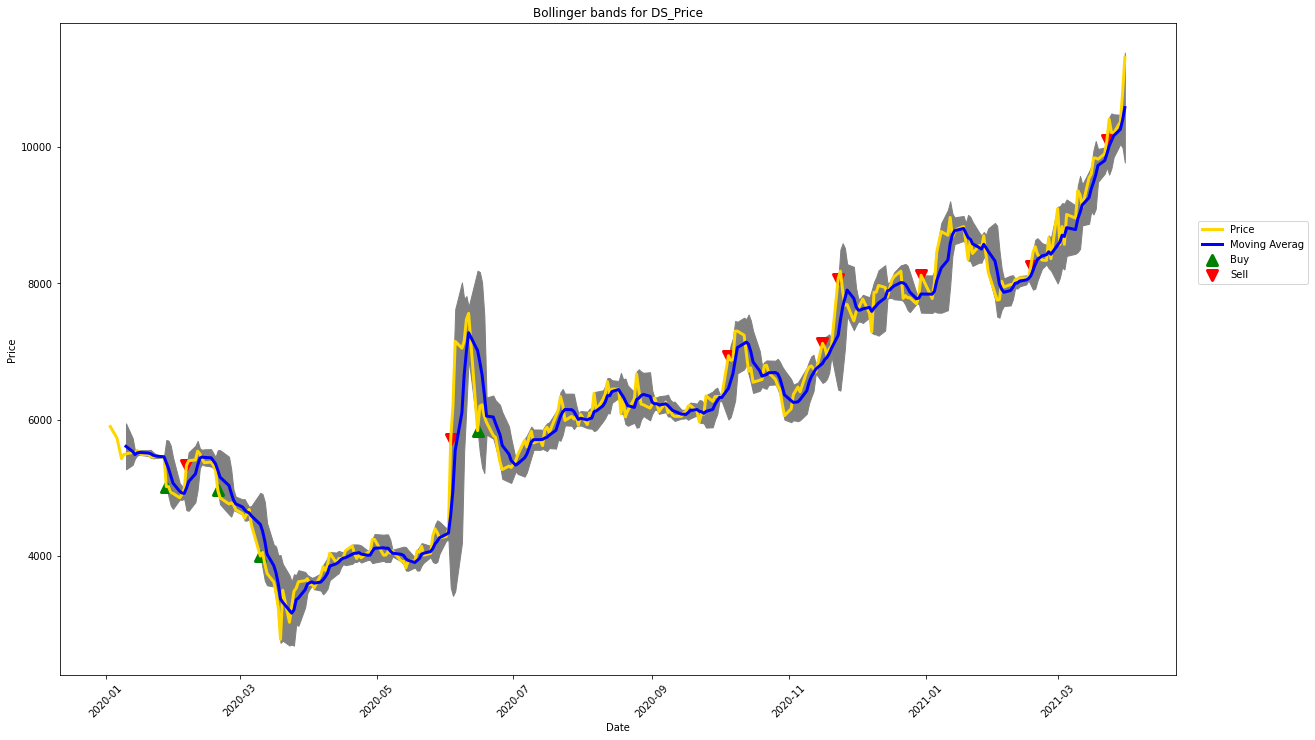

In [116]:
# Bollinger bands for the actual data daily

bollinger_bands(df = predicted_df, col = 'DS_Price', p = 5, std = 1.7)

In [117]:
# Check the actual vs the predicted returns

capital_gain_predicted_prices(df1 = test['DS_Price'], df2 = predictions_df['DS_Price'])

The actual returns had a value of 57.26% and the predicted returns had a value 45.38%
